In [7]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import shutil

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, 
    precision_recall_curve, roc_curve, auc
)

**Crear Carpeta crops_90x90_lesiones**

In [13]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Directorio de imágenes de origen
base_dir = 'crops_90x90'
output_dir = 'crops_90x90_lesiones'  # Carpeta base de salida

# Crear carpetas de salida para entrenamiento, validación y prueba
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

# Crear subcarpetas si no existen
for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

# Para cada clase dentro de crops_90x90, dividir en train, val y test, excluyendo la carpeta 'Negative'
for class_name in os.listdir(base_dir):
    if class_name == 'Negative':  # Omitir la carpeta 'Negative'
        continue
        
    class_path = os.path.join(base_dir, class_name)
    
    # Asegurarse de que es una carpeta
    if not os.path.isdir(class_path):
        continue
    
    # Crear subcarpetas para cada clase en train, val y test
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Obtener todas las imágenes de la clase
    images = os.listdir(class_path)
    images = [os.path.join(class_path, img) for img in images]

    # Dividir imágenes en train, val y test
    train_images, test_images = train_test_split(images, test_size=0.3, random_state=42)
    val_images, test_images = train_test_split(test_images, test_size=0.5, random_state=42)  # Divide 50-50 para val y test

    # Copiar las imágenes a las carpetas correspondientes
    for img_path in train_images:
        shutil.copy(img_path, os.path.join(train_dir, class_name))

    for img_path in val_images:
        shutil.copy(img_path, os.path.join(val_dir, class_name))

    for img_path in test_images:
        shutil.copy(img_path, os.path.join(test_dir, class_name))

print("Imágenes organizadas en carpetas de entrenamiento, validación y prueba.")

Imágenes organizadas en carpetas de entrenamiento, validación y prueba.


**Generador**

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Crear generadores de datos
train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Cargar imágenes desde los directorios
train_generator = train_datagen.flow_from_directory(
    'crops_90x90_lesiones/train',
    target_size=(90, 90),
    batch_size=32,
    class_mode='categorical'  # Clasificación multiclase
)

val_generator = val_test_datagen.flow_from_directory(
    'crops_90x90_lesiones/val',
    target_size=(90, 90),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    'crops_90x90_lesiones/test',
    target_size=(90, 90),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 3327 images belonging to 5 classes.
Found 713 images belonging to 5 classes.
Found 715 images belonging to 5 classes.


## MovileNetV2

In [15]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Cargar MobileNetV2 preentrenado en ImageNet, sin la capa superior
base_model = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Congelar las capas del modelo base
base_model.trainable = False

# Construir el modelo de clasificación
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')  # Clasificación multiclase
])

# Descongelar algunas capas del modelo base
for layer in base_model.layers[-10:]:
    layer.trainable = True


# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',  # Pérdida para multiclase
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Configurar callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('mejor_modelo_lesiones.h5', monitor='val_loss', save_best_only=True, mode='min')

# Entrenar el modelo
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/30
104/104 [==============================] - 8s 63ms/step - loss: 1.8204 - accuracy: 0.3228 - precision: 0.3531 - recall: 0.1966 - auc: 0.6424 - val_loss: 1.4516 - val_accuracy: 0.4642 - val_precision: 0.5185 - val_recall: 0.2945 - val_auc: 0.7607
Epoch 2/30
  1/104 [..............................] - ETA: 8s - loss: 1.6202 - accuracy: 0.4062 - precision: 0.5000 - recall: 0.2500 - auc: 0.6870

/Users/achula/miniconda3/envs/td8/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


104/104 [==============================] - 7s 64ms/step - loss: 1.4755 - accuracy: 0.4022 - precision: 0.4611 - recall: 0.2101 - auc: 0.7242 - val_loss: 1.3351 - val_accuracy: 0.4741 - val_precision: 0.5964 - val_recall: 0.3254 - val_auc: 0.7850
Epoch 3/30
104/104 [==============================] - 6s 59ms/step - loss: 1.3372 - accuracy: 0.4491 - precision: 0.5461 - recall: 0.2597 - auc: 0.7681 - val_loss: 1.2675 - val_accuracy: 0.5133 - val_precision: 0.6162 - val_recall: 0.3310 - val_auc: 0.8014
Epoch 4/30
104/104 [==============================] - 6s 57ms/step - loss: 1.2804 - accuracy: 0.4662 - precision: 0.5515 - recall: 0.2477 - auc: 0.7843 - val_loss: 1.2360 - val_accuracy: 0.5189 - val_precision: 0.6253 - val_recall: 0.3254 - val_auc: 0.8101
Epoch 5/30
104/104 [==============================] - 6s 60ms/step - loss: 1.2186 - accuracy: 0.4887 - precision: 0.6014 - recall: 0.2861 - auc: 0.8043 - val_loss: 1.2008 - val_accuracy: 0.5442 - val_precision: 0.6241 - val_recall: 0.3492 -

In [16]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")

23/23 [==============================] - 1s 50ms/step - loss: 1.0434 - accuracy: 0.5902 - precision: 0.6692 - recall: 0.4951 - auc: 0.8652
Test Loss: 1.043407917022705
Test Accuracy: 0.5902097821235657
Test Precision: 0.6691871285438538
Test Recall: 0.49510490894317627
Test AUC: 0.8652258515357971


23/23 [==============================] - 1s 50ms/step


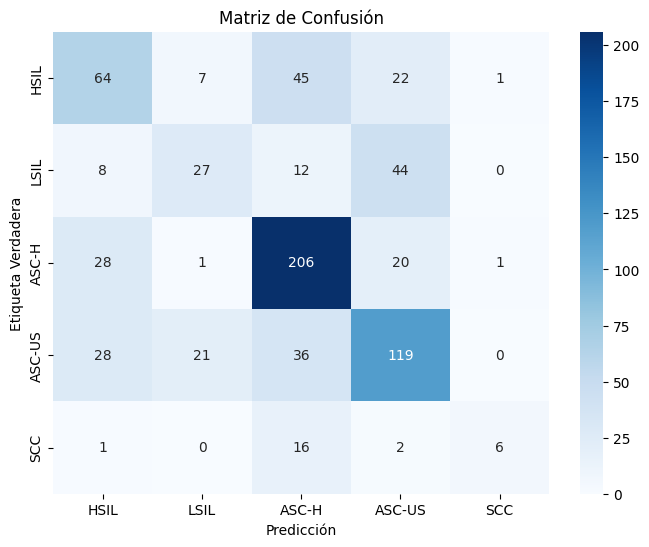

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Obtener las predicciones y etiquetas verdaderas
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_generator.classes

# Nombres de las clases (ajusta según tus clases)
class_names = ['HSIL', 'LSIL', 'ASC-H', 'ASC-US', 'SCC']

# Generar la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.show()

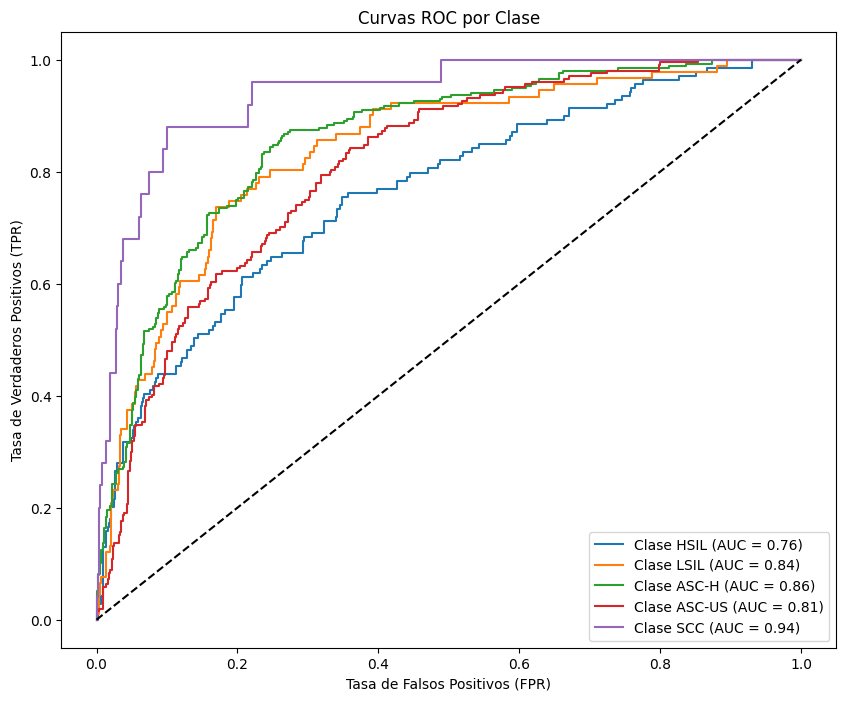

In [20]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Binarizar las etiquetas verdaderas
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4])  # Ajustar según la cantidad de clases

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()